In [1]:
import numpy as np
import argparse

# root_utils in parent directory
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
from root_utils import pos_utils

In [2]:
geo_npz_file = np.load("/project/6008045/jwalker/graph_ml/visualisation/full_geo_dump.npz", allow_pickle=True)
#eminus_npz_file = np.load("/project/6008045/jwalker/graph_ml/visualisation/npz_e-.npz", allow_pickle=True)
#neutron_npz_file = np.load("/project/6008045/jwalker/graph_ml/visualisation/npz_neutron.npz", allow_pickle=True)
eminus_npz_file = np.load("/project/6008045/machine_learning/data/IWCDshort_ncapt/numpy/e-/E0to20MeV/unif-pos-R400-y300cm/4pi-dir/IWCDshort_ncapt_e-_E0to20MeV_unif-pos-R400-y300cm_4pi-dir_100evts_1.npz", allow_pickle=True)
neutron_npz_file = np.load("/project/6008045/machine_learning/data/IWCDshort_ncapt/numpy/neutron/E1to1MeV/unif-pos-R400-y300cm/4pi-dir/IWCDshort_ncapt_neutron_E1to1MeV_unif-pos-R400-y300cm_4pi-dir_100evts_0.npz", allow_pickle=True)


In [3]:
print( list(geo_npz_file.keys()) )
#print( list(eminus_npz_file.keys()) )
print( list(neutron_npz_file.keys()) )
#print( geo_npz_file['tube_no'] )
#print( geo_npz_file['position'] )
print( neutron_npz_file['energy'] )
#print( neutron_npz_file['digi_hit_charge'] )

['tube_no', 'position', 'orientation']
['event_id', 'root_file', 'pid', 'position', 'direction', 'energy', 'digi_hit_pmt', 'digi_hit_charge', 'digi_hit_time', 'digi_hit_trigger', 'true_hit_pmt', 'true_hit_time', 'true_hit_pos', 'true_hit_start_time', 'true_hit_start_pos', 'true_hit_parent', 'track_id', 'track_pid', 'track_start_time', 'track_energy', 'track_start_position', 'track_stop_position', 'track_parent', 'track_flag', 'trigger_time']
[940.56536865 940.56536865 940.56536865 940.56536865 940.56536865
 940.56536865 940.56536865 940.56536865 940.56536865 940.56536865
 940.56536865 940.56536865 940.56536865 940.56536865 940.56536865
 940.56536865 940.56536865 940.56536865 940.56536865 940.56536865
 940.56536865 940.56536865 940.56536865 940.56536865 940.56536865
 940.56536865 940.56536865 940.56536865 940.56536865 940.56536865
 940.56536865 940.56536865 940.56536865 940.56536865 940.56536865
 940.56536865 940.56536865 940.56536865 940.56536865 940.56536865
 940.56536865 940.56536865

# Understanding the default functionality for matching PMT to an index

```
The index starts at 0 and counts up continuously with no gaps
The tube_no starts at 1 and counts up continuously with no gaps
Each 19 consecutive PMTs belong to one mPMT module, so (index)/19 is the module number.
Each 19 consecutive PMTs belong to one mPMT module, so (tube_no-1)/19 is the module number.
The (index+1)%19 gives the position in the module: 1-12 is the outer ring, 13-18 is inner ring, 0 is the centre PMT
The tube_no%19 gives the position in the module: 1-12 is the outer ring, 13-18 is inner ring, 0 is the centre PMT
The modules are then ordered as follows:
It starts by going round the second highest ring around the barrel, then the third highest ring, fourth highest
ring, all the way down to the lowest ring (i.e. skips the highest ring).
Then does the bottom end-cap, row by row (the first row has 6 modules, the second row has 8, then 10, 10, 10,
10, 10, 10, 8, 6).
Then the highest ring around the barrel that was skipped before, then the top end-cap, row by row.
I'm not sure why it has this somewhat strange order...
WTF: actually it is: 2, 6, 8 10, 10, 12 and down again in the caps
```

Taken from `root_utils/pos_util.py`


- `module_index`: returns the mPMT index
- `pmt_in_module_id`: this will be a value between 0 and 18 inclusive
- `is_barrel`, `is_bottom`, `is_top`: the input is the mPMT index

There are more functions for rearrranging the row col into images they are confusing, so i didn't bother. Just look at `root_utils/pos_util.py`

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

# Plot mPMT
On the barrel
0 based indexing the center is n%19 = 18

Text(0, 0.5, 'y')

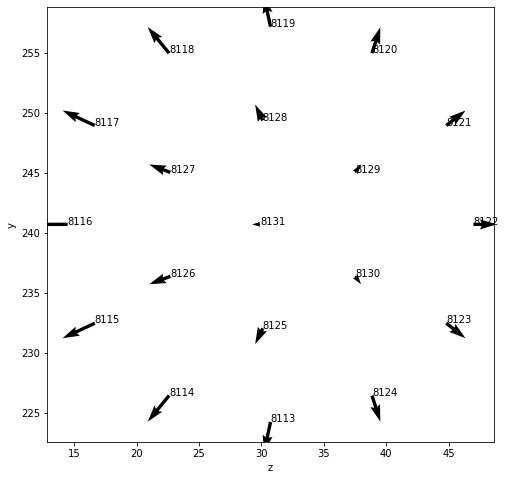

In [5]:
mPMT_number = 427

x = []
y = []
z = []

dx = []
dy = []
dz = []
indicies = []
for PMT_index in range(mPMT_number*19, mPMT_number*19+19):
    x.append(geo_npz_file['position'][PMT_index][0])
    y.append(geo_npz_file['position'][PMT_index][1])
    z.append(geo_npz_file['position'][PMT_index][2])
    dx.append(geo_npz_file['orientation'][PMT_index][0])
    dy.append(geo_npz_file['orientation'][PMT_index][1])
    dz.append(geo_npz_file['orientation'][PMT_index][2])
    indicies.append(PMT_index)
    
plt.figure(figsize=(8,8))
ax = plt.gca()

plt.quiver(z, y, dz, dy)
for i, index in enumerate(indicies):
     ax.annotate(index, (z[i], y[i]))
plt.xlabel("z")
plt.ylabel("y")

Text(0, 0.5, 'y')

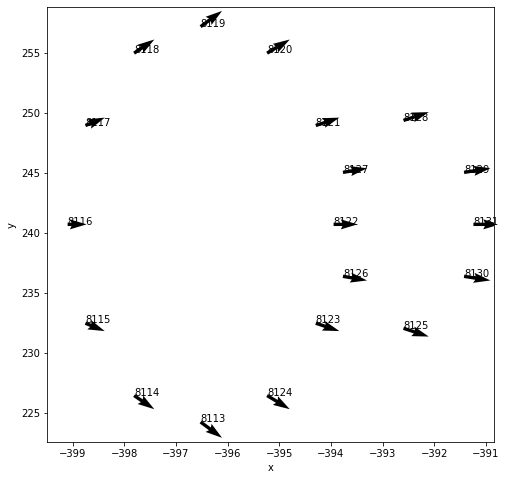

In [6]:
plt.figure(figsize=(8,8))
ax = plt.gca()
plt.quiver(x, y, dx, dy)
for i, index in enumerate(indicies):
     ax.annotate(index, (x[i], y[i]))
plt.xlabel("x")
plt.ylabel("y")

# Plot barrel

In [7]:
def is_barrel( position ):
    if position[1] > -280.0 and position[1] < 280.0:
        return True
    else:
        return False
    
def is_top( position ):
    if position[1] > 280.0:
        return True
    else:
        return False
    
def is_bottom( position ):
    if position[1] < -280.0:
        return True
    else:
        return False
    
def is_top_ring( position ):
    if position[1] > 200.0 and position[1] < 280.0:
        return True
    else:
        return False
    
def is_bottom_ring( position ):
    if position[1] > -280.0 and position[1] < -220.0:
        return True
    else:
        return False

In [8]:
x = []
y = []
z = []
indicies = []
num_pmts = len( geo_npz_file['tube_no'][:] )
for mPMT_index in range(num_pmts//19):
    PMT_index = mPMT_index * 19
    if is_barrel( geo_npz_file['position'][PMT_index] ):
        x.append(geo_npz_file['position'][PMT_index][0])
        y.append(geo_npz_file['position'][PMT_index][1])
        z.append(geo_npz_file['position'][PMT_index][2])
        indicies.append(mPMT_index)

Text(0, 0.5, 'y')

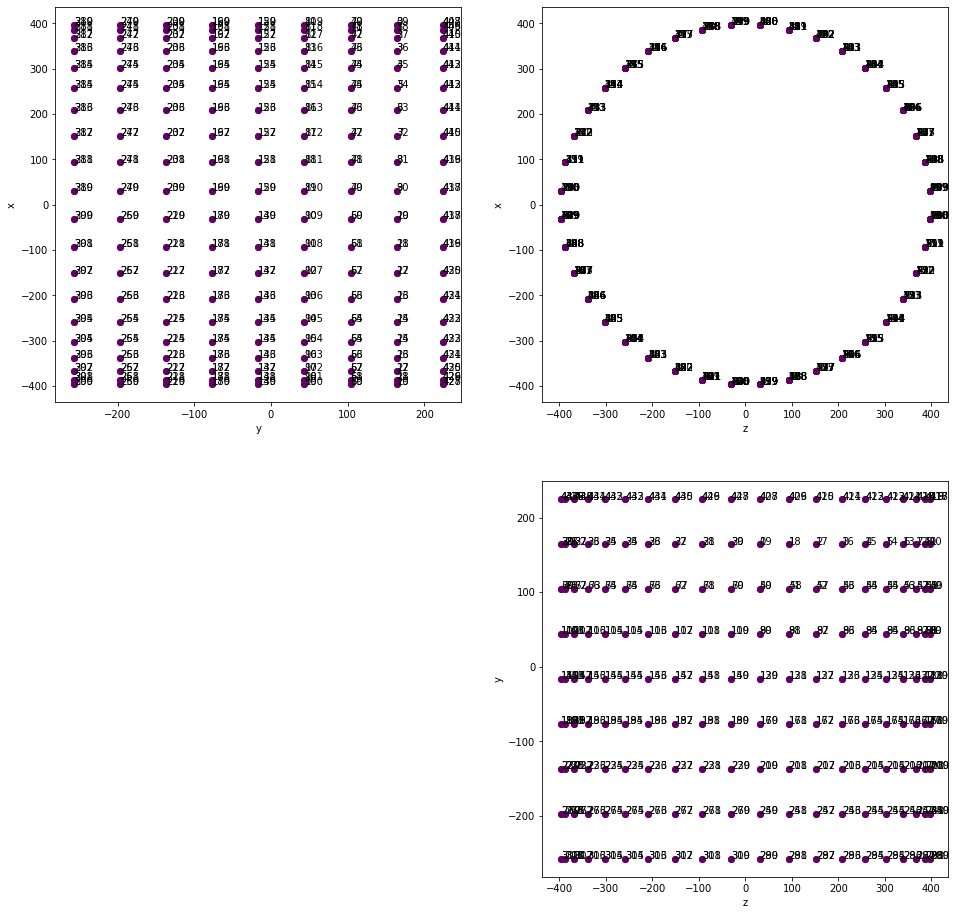

In [9]:
fig = plt.figure(figsize=(16,16))

ax = fig.add_subplot(221)
plt.scatter(y, x, color="#660066")
for i, index in enumerate(indicies):
     ax.annotate(index, (y[i], x[i]))
plt.xlabel("y")
plt.ylabel("x")

ax = fig.add_subplot(222)
plt.scatter(z, x, color="#660066")
for i, index in enumerate(indicies):
     ax.annotate(index, (z[i], x[i]))
plt.xlabel("z")
plt.ylabel("x")        
        
ax = fig.add_subplot(224)
plt.scatter(z, y, color="#660066")
for i, index in enumerate(indicies):
     ax.annotate(index, (z[i], y[i]))
plt.xlabel("z")
plt.ylabel("y")      

Text(0, 0.5, 'y')

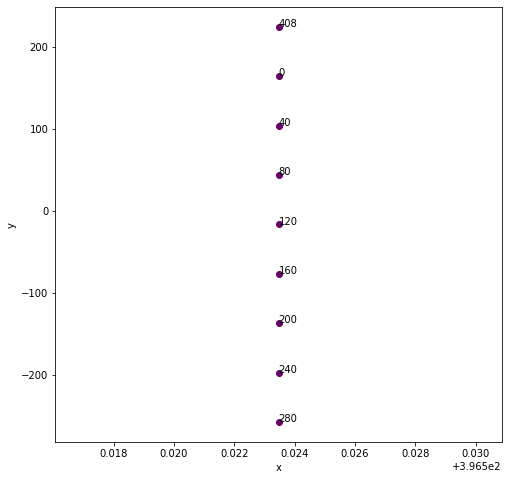

In [10]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
plt.scatter(x[::40], y[::40], color="#660066") # 40 comes from the fact there is 40 mPMT at each height
for i, index in enumerate(indicies[::40]):
     ax.annotate(index, (x[i*40], y[i*40]))
plt.xlabel("x")
plt.ylabel("y")

# Plotting the top endcap

In [11]:
x = []
y = []
z = []

dx = []
dy = []
dz = []

indicies = [] # Note this will be 1 off from PMT number

rx = []
ry = []
rz = []
rindicies = []
for mPMT_index in range(num_pmts//19):
    
    PMT_index = mPMT_index * 19
    
    if is_top( geo_npz_file['position'][PMT_index] ):
        x.append(geo_npz_file['position'][PMT_index][0])
        y.append(geo_npz_file['position'][PMT_index][1])
        z.append(geo_npz_file['position'][PMT_index][2])
        dx.append(geo_npz_file['orientation'][PMT_index][0])
        dy.append(geo_npz_file['orientation'][PMT_index][1])
        dz.append(geo_npz_file['orientation'][PMT_index][2])
        indicies.append(mPMT_index)
        
    if is_top_ring( geo_npz_file['position'][PMT_index] ):
        rx.append(geo_npz_file['position'][PMT_index][0])
        ry.append(geo_npz_file['position'][PMT_index][1])
        rz.append(geo_npz_file['position'][PMT_index][2])
        rindicies.append(mPMT_index)

In [12]:
print("Top encap is at height (y) = ", y[0])
print("Top ring is at height (y) = ", ry[0])

Top encap is at height (y) =  296.4490661621094
Top ring is at height (y) =  224.2531280517578


Text(0, 0.5, 'z')

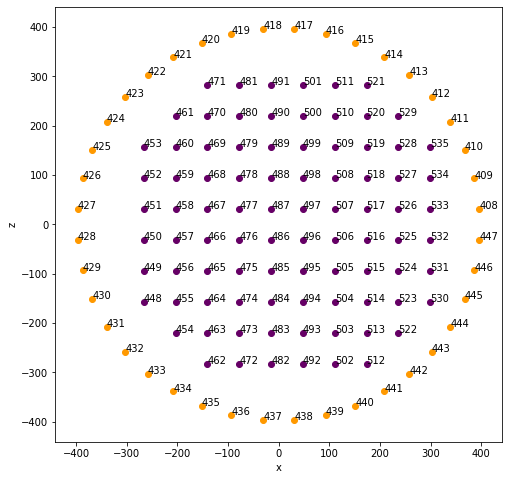

In [13]:
plt.figure(figsize=(8,8))
ax = plt.gca()

plt.scatter(x, z, color="#660066")
for i, index in enumerate(indicies):
     ax.annotate(index, (x[i], z[i]))
        
plt.scatter(rx, rz, color="#ff9900")
for i, index in enumerate(rindicies):
     ax.annotate(index, (rx[i], rz[i]))
plt.xlabel("x")
plt.ylabel("z")

Text(0, 0.5, 'y')

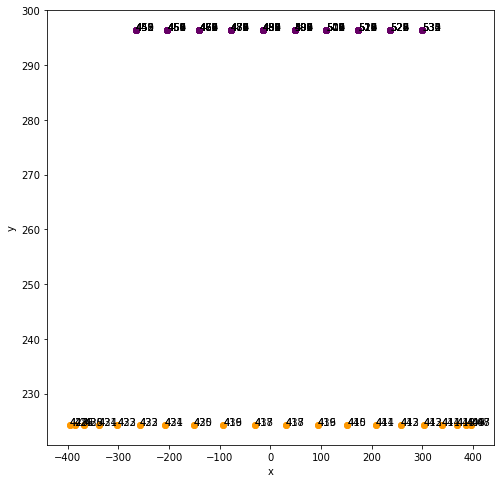

In [14]:
plt.figure(figsize=(8,8))
ax = plt.gca()

plt.scatter(x, y, color="#660066")
for i, index in enumerate(indicies):
     ax.annotate(index, (x[i], y[i]))
        
plt.scatter(rx, ry, color="#ff9900")
for i, index in enumerate(rindicies):
     ax.annotate(index, (rx[i], ry[i]))
plt.xlabel("x")
plt.ylabel("y")

Text(0, 0.5, 'z')

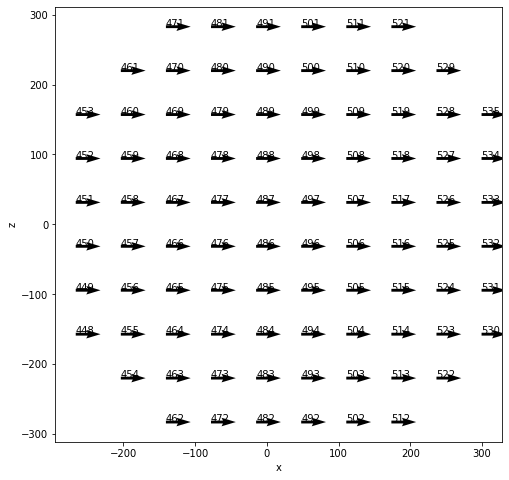

In [15]:
# Note that this orientation is the orientation of node 0 of the mPMT. (in the outer ring)

plt.figure(figsize=(8,8))
ax = plt.gca()

plt.quiver(x, z, dx, dz)
for i, index in enumerate(indicies):
     ax.annotate(index, (x[i], z[i]))
plt.xlabel("x")
plt.ylabel("z")

# Plotting the bottom endcap

In [16]:
x = []
y = []
z = []

dx = []
dy = []
dz = []

indicies = [] # Note this will be 1 off from PMT number

rx = []
ry = []
rz = []
rindicies = []
for mPMT_index in range(num_pmts//19):
    
    PMT_index = mPMT_index * 19
    
    if is_bottom( geo_npz_file['position'][PMT_index] ):
        x.append(geo_npz_file['position'][PMT_index][0])
        y.append(geo_npz_file['position'][PMT_index][1])
        z.append(geo_npz_file['position'][PMT_index][2])
        dx.append(geo_npz_file['orientation'][PMT_index][0])
        dy.append(geo_npz_file['orientation'][PMT_index][1])
        dz.append(geo_npz_file['orientation'][PMT_index][2])
        indicies.append(mPMT_index)
        
    if is_bottom_ring( geo_npz_file['position'][PMT_index] ):
        rx.append(geo_npz_file['position'][PMT_index][0])
        ry.append(geo_npz_file['position'][PMT_index][1])
        rz.append(geo_npz_file['position'][PMT_index][2])
        rindicies.append(mPMT_index)

In [17]:
print("Bottom endcap is at height (y) = ", y[0])
print("Bottom ring is at height (y) = ", ry[0])

Bottom endcap is at height (y) =  -296.4490661621094
Bottom ring is at height (y) =  -257.1690979003906


Text(0, 0.5, 'z')

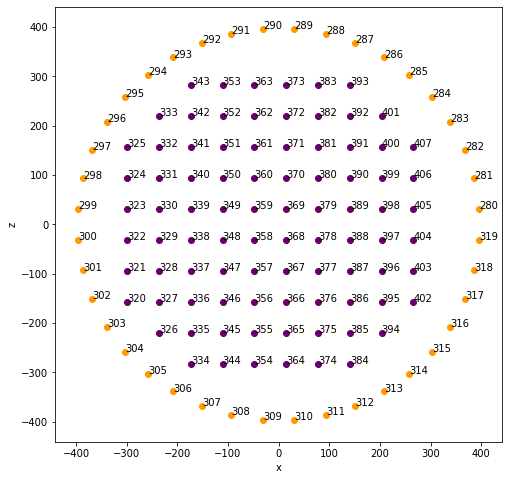

In [18]:
plt.figure(figsize=(8,8))
ax = plt.gca()

plt.scatter(x, z, color="#660066")
for i, index in enumerate(indicies):
     ax.annotate(index, (x[i], z[i]))
        
plt.scatter(rx, rz, color="#ff9900")
for i, index in enumerate(rindicies):
     ax.annotate(index, (rx[i], rz[i]))
plt.xlabel("x")
plt.ylabel("z")

Text(0, 0.5, 'y')

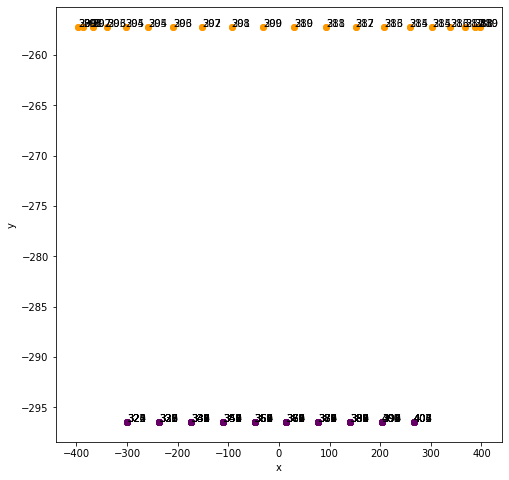

In [19]:
plt.figure(figsize=(8,8))
ax = plt.gca()

plt.scatter(x, y, color="#660066")
for i, index in enumerate(indicies):
     ax.annotate(index, (x[i], y[i]))
        
plt.scatter(rx, ry, color="#ff9900")
for i, index in enumerate(rindicies):
     ax.annotate(index, (rx[i], ry[i]))
plt.xlabel("x")
plt.ylabel("y")

Text(0, 0.5, 'z')

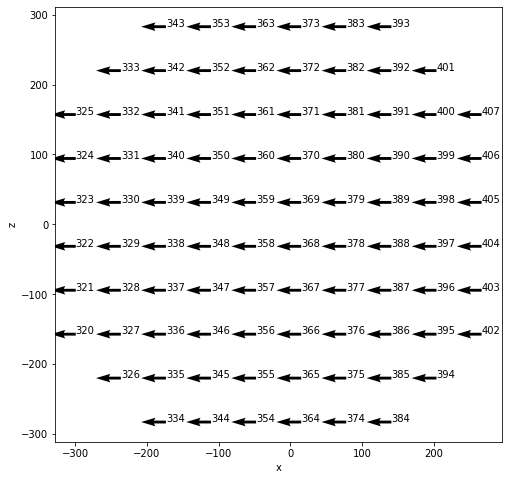

In [20]:
# Note that this orientation is the orientation of node 0 of the mPMT. (in the outer ring)

plt.figure(figsize=(8,8))
ax = plt.gca()

plt.quiver(x, z, dx, dz)
for i, index in enumerate(indicies):
     ax.annotate(index, (x[i], z[i]))
plt.xlabel("x")
plt.ylabel("z")

# Map the index to an image
mPMT modules mapped to rows and columns in mPMT_to_row_col.csv
Then load the CSV file and turn it into a dictionary

In [21]:
csv_file = "mPMT_to_row_col.csv"
def GenMapping(csv_file):
    mPMT_to_index = {}
    with open(csv_file) as f:
        rows = f.readline().split(",")[1:]
        rows = [int(r.strip()) for r in rows]

        for line in f:
            line_split = line.split(",")
            col = int(line_split[0].strip())
            for row, value in zip(rows, line_split[1:]):
                value = value.strip()
                if value: # If the value is not empty
                    mPMT_to_index[int(value)] = [row, col]
    return mPMT_to_index

mPMT_to_index = GenMapping(csv_file)

In [22]:
def gen_mpmt_mapping():
    xs = []
    ys = []
    mapping = []
    # Outer ring
    for i in range(12):
        theta = 2*np.pi*i/12
        mapping.append([-0.4*np.sin(theta), -0.4*np.cos(theta)])
    # Inner ring
    for i in range(6):
        theta = 2*np.pi*i/6
        mapping.append([-0.2*np.sin(theta), -0.2*np.cos(theta)])
    # Center point
    mapping.append([0, 0])
    return mapping

def mpmt_mapping(_pmt_index):
    _pmt_in_module_id = _pmt_index%19
    _module_index = _pmt_index//19
    if _pmt_in_module_id >= 0 and _pmt_in_module_id<12:
        _theta = 2*np.pi*_pmt_in_module_id/12
        _radius = 0.4
    elif _pmt_in_module_id >= 12 and _pmt_in_module_id<18:
        _theta = 2*np.pi*(_pmt_in_module_id-12)/6
        _radius = 0.2
    else:
        _theta = 0
        _radius = 0
    if not pos_utils.is_barrel(_module_index):
        _theta = _theta+np.pi
    _mapping = [-_radius*np.sin(_theta), -_radius*np.cos(_theta)]
    return _mapping
    
PMT_to_index = gen_mpmt_mapping()

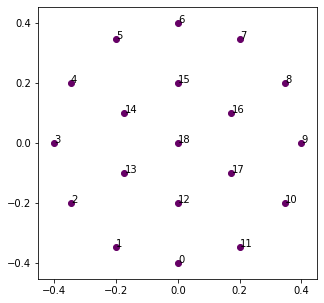

In [23]:
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
xs = []
ys = []
for i in range(19):
    xs.append(mpmt_mapping(i)[0])
    ys.append(mpmt_mapping(i)[1])
#for map in PMT_to_index:
#    xs.append(map[0])
#    ys.append(map[1])
# Plot
ax.scatter(xs, ys, color="#660066")
for i in range(19):
     ax.annotate(i, (xs[i], ys[i]))

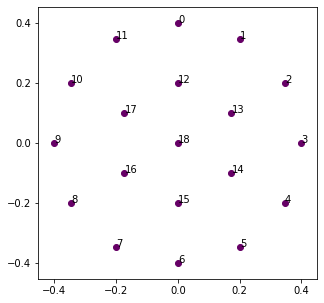

In [43]:
fig = plt.figure(figsize=(5,5))
ax = fig.gca()
xs = []
ys = []
for i in range(487*19,487*19+19):
    xs.append(mpmt_mapping(i)[0])
    ys.append(mpmt_mapping(i)[1])
#for map in PMT_to_index:
#    xs.append(map[0])
#    ys.append(map[1])
# Plot
ax.scatter(xs, ys, color="#660066")
for i in range(19):
     ax.annotate(i, (xs[i], ys[i]))

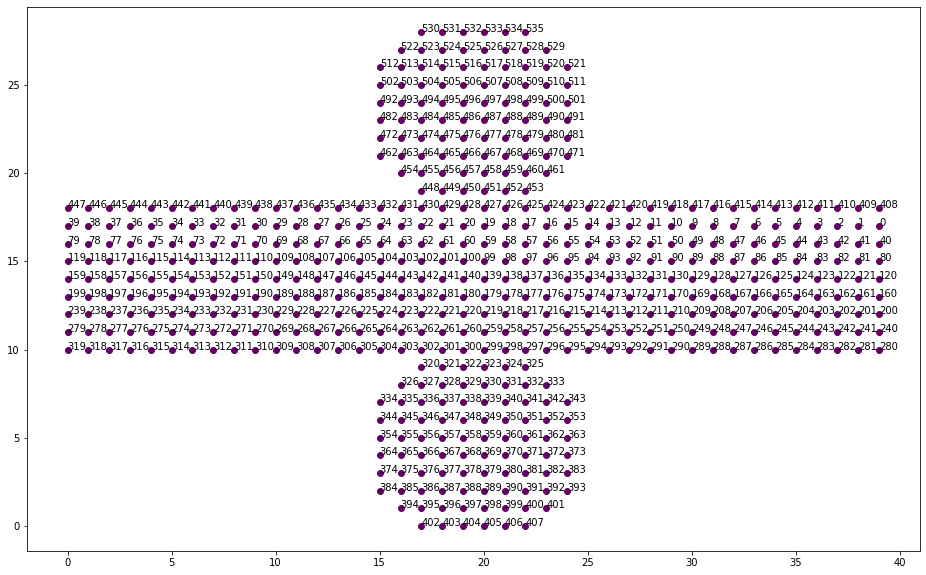

In [24]:
xs = []
ys = []
texts = []
for mPMT_index in range(num_pmts//19):
    index = mPMT_to_index[mPMT_index]
    xs.append(index[0])
    ys.append(index[1])
    texts.append(mPMT_index)

fig = plt.figure(figsize=(16,10))
ax = fig.gca()
ax.scatter(xs, ys, color="#660066")
for x, y, text in zip(xs, ys, texts):
    ax.annotate(text, (x,y))

# Look at orientation to figure out order of PMTs in mPMT

In [25]:
xs = []
ys = []

dxs = []
dys = []
dzs = []

for mPMT_index in range(num_pmts//19):    
    index = mPMT_to_index[mPMT_index]
    xs.append(index[0])
    ys.append(index[1])
    PMT_index = mPMT_index * 19 + 18 # 18 is centre of the mPMT
    dxs.append(geo_npz_file['orientation'][PMT_index][0])
    dys.append(geo_npz_file['orientation'][PMT_index][1])
    dzs.append(geo_npz_file['orientation'][PMT_index][2])

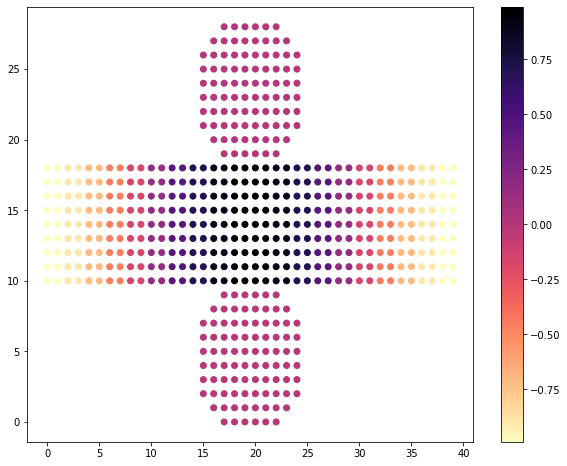

In [26]:
plt.figure(figsize=(10,8))
plot = plt.scatter(xs, ys, c=dxs, cmap=plt.cm.magma_r)
plt.colorbar(plot)

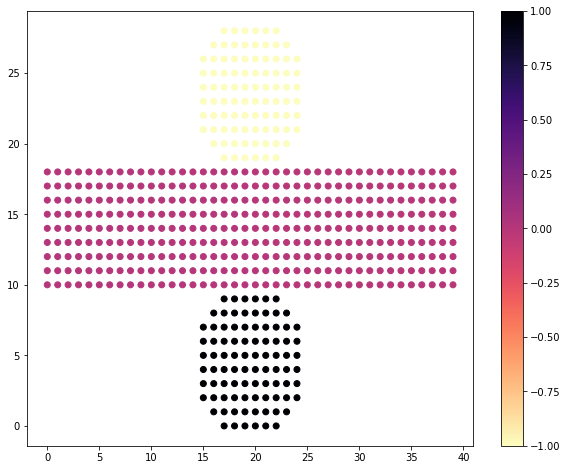

In [27]:
plt.figure(figsize=(10,8))
plot = plt.scatter(xs, ys, c=dys, cmap=plt.cm.magma_r)
plt.colorbar(plot)

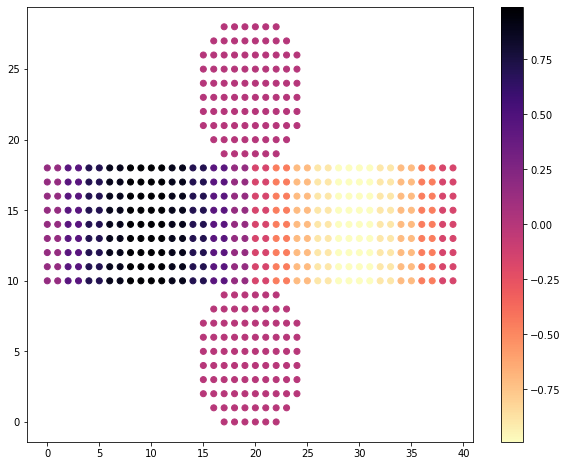

In [28]:
plt.figure(figsize=(10,8))
plot = plt.scatter(xs, ys, c=dzs, cmap=plt.cm.magma_r)
plt.colorbar(plot)

In [29]:
xs = []
ys = []

dxs = []
dys = []
dzs = []

for mPMT_index in range(num_pmts//19):    
    index = mPMT_to_index[mPMT_index]
    xs.append(index[0])
    ys.append(index[1])
    PMT_index = mPMT_index * 19 + 0 # 0 is in outer ring of the mPMT
    dxs.append(geo_npz_file['orientation'][PMT_index][0])
    dys.append(geo_npz_file['orientation'][PMT_index][1])
    dzs.append(geo_npz_file['orientation'][PMT_index][2])

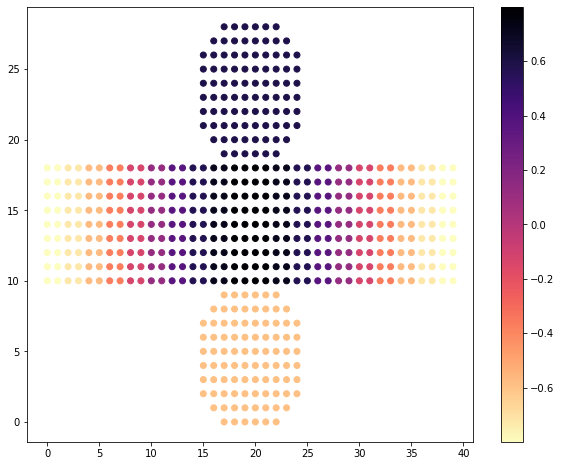

In [30]:
plt.figure(figsize=(10,8))
plot = plt.scatter(xs, ys, c=dxs, cmap=plt.cm.magma_r)
plt.colorbar(plot)

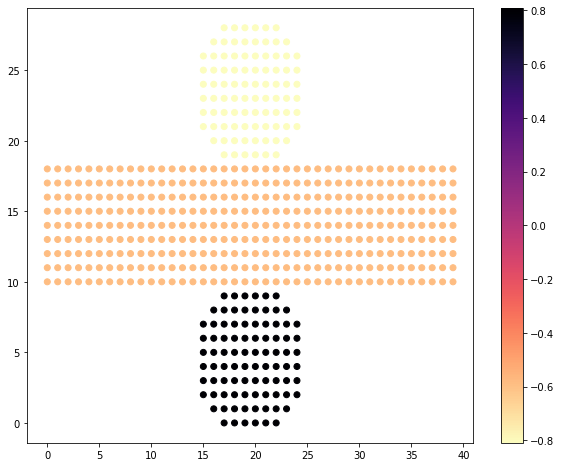

In [31]:
plt.figure(figsize=(10,8))
plot = plt.scatter(xs, ys, c=dys, cmap=plt.cm.magma_r)
plt.colorbar(plot)

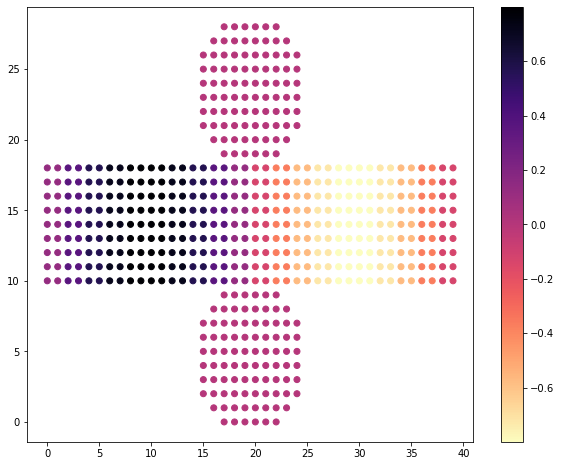

In [32]:
plt.figure(figsize=(10,8))
plot = plt.scatter(xs, ys, c=dzs, cmap=plt.cm.magma_r)
plt.colorbar(plot)

# Plot mPMT orientation

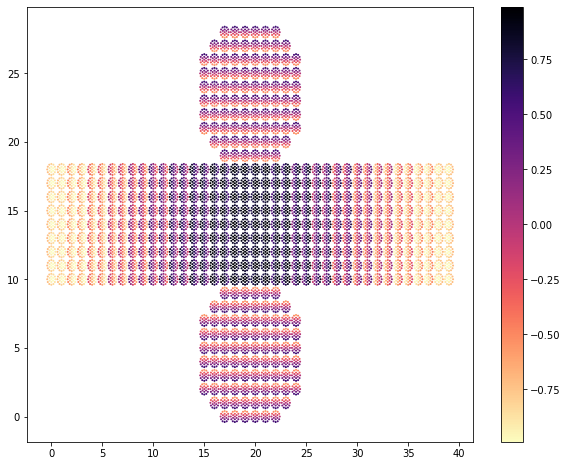

In [33]:
xs = []
ys = []

dxs = []
dys = []
dzs = []

for PMT_index in range(num_pmts):
    mPMT_index = PMT_index//19
    mPMT_pos = mPMT_to_index[mPMT_index]
    PMT_map = mpmt_mapping(PMT_index)
    PMT_pos = [ mPMT_pos[0]+PMT_map[0], mPMT_pos[1]+PMT_map[1] ]
    xs.append(PMT_pos[0])
    ys.append(PMT_pos[1])
    dxs.append(geo_npz_file['orientation'][PMT_index][0])
    dys.append(geo_npz_file['orientation'][PMT_index][1])
    dzs.append(geo_npz_file['orientation'][PMT_index][2])
    
plt.figure(figsize=(10,8))
plot = plt.scatter(xs, ys, c=dxs, s=1, cmap=plt.cm.magma_r)
plt.colorbar(plot)

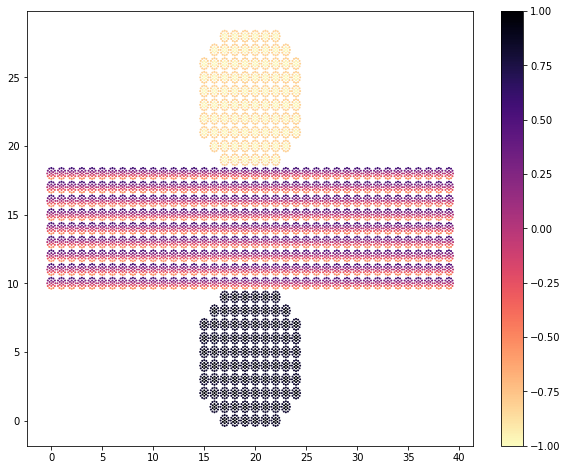

In [34]:
plt.figure(figsize=(10,8))
plot = plt.scatter(xs, ys, c=dys, s=1, cmap=plt.cm.magma_r)
plt.colorbar(plot)

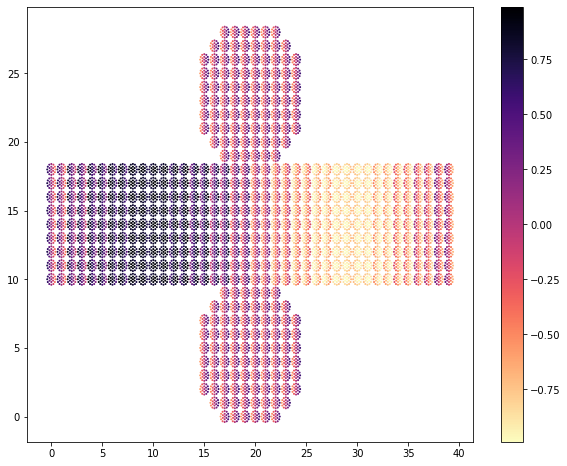

In [35]:
plt.figure(figsize=(10,8))
plot = plt.scatter(xs, ys, c=dzs, s=1, cmap=plt.cm.magma_r)
plt.colorbar(plot)

# Plot an electron event with mPMTs as the geometry

In [36]:
event_number = 2
charges = np.zeros( num_pmts//19 )
xs = []
ys = []

for mPMT_index in range(num_pmts//19):    
    index = mPMT_to_index[mPMT_index]
    xs.append(index[0])
    ys.append(index[1])
    
ev_npz_pmts    = eminus_npz_file['digi_hit_pmt']
ev_npz_charges = eminus_npz_file['digi_hit_charge']
ev_npz_times   = eminus_npz_file['digi_hit_time']

#print(ev_npz_pmts[event_number])
#print(ev_npz_charges[event_number])
#print(ev_npz_times[event_number])

# Assert that charges/times match number of hit PMTs
assert( len(ev_npz_pmts[event_number]) == len(ev_npz_charges[event_number]) )
assert( len(ev_npz_charges[event_number]) == len(ev_npz_times[event_number]) )

for index, pmt in enumerate( ev_npz_pmts[event_number] ):
    mPMT_index = pos_utils.module_index( pmt )
    charges[mPMT_index] = charges[mPMT_index] + ev_npz_charges[event_number][index]

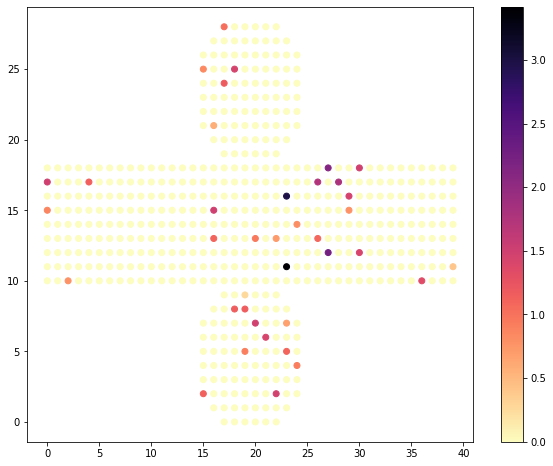

In [37]:
plt.figure(figsize=(10,8))
plot = plt.scatter(xs, ys, c=charges, cmap=plt.cm.magma_r)
plt.colorbar(plot)

# Plot a neutron event with mPMTs as the geometry

40
40
40


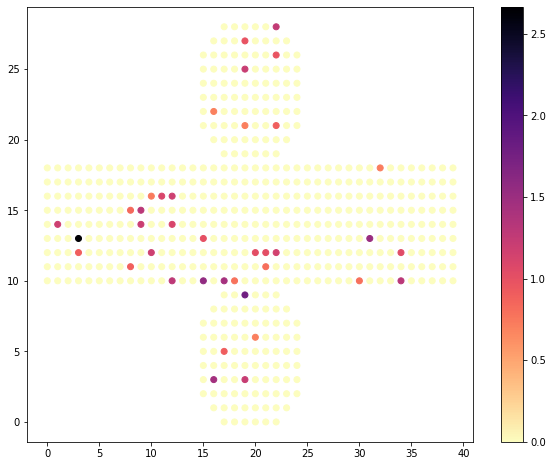

In [38]:
event_number = 4
charges = np.zeros( num_pmts//19 )
xs = []
ys = []

for mPMT_index in range(num_pmts//19):    
    index = mPMT_to_index[mPMT_index]
    xs.append(index[0])
    ys.append(index[1])
    
ev_npz_pmts    = neutron_npz_file['digi_hit_pmt']
ev_npz_charges = neutron_npz_file['digi_hit_charge']
ev_npz_times   = neutron_npz_file['digi_hit_time']

print(len(ev_npz_pmts[event_number]))
print(len(ev_npz_charges[event_number]))
print(len(ev_npz_times[event_number]))

# Assert that charges/times match number of hit PMTs
assert( len(ev_npz_pmts[event_number]) == len(ev_npz_charges[event_number]) )
assert( len(ev_npz_charges[event_number]) == len(ev_npz_times[event_number]) )

for index, pmt in enumerate( ev_npz_pmts[event_number] ):
    mPMT_index = pos_utils.module_index( pmt )
    charges[mPMT_index] = charges[mPMT_index] + ev_npz_charges[event_number][index]
    
plt.figure(figsize=(10,8))
plot = plt.scatter(xs, ys, c=charges, cmap=plt.cm.magma_r)
plt.colorbar(plot)

# Plot an electron event with PMTs as the geometry

In [39]:
event_number = 2
charges = np.zeros( num_pmts )
xs = []
ys = []

for PMT_index in range(num_pmts):
    mPMT_index = PMT_index//19
    mPMT_pos = mPMT_to_index[mPMT_index]
    PMT_map = mpmt_mapping(PMT_index)
    PMT_pos = [ mPMT_pos[0]+PMT_map[0], mPMT_pos[1]+PMT_map[1] ]
    xs.append(PMT_pos[0])
    ys.append(PMT_pos[1])
    
ev_npz_pmts    = eminus_npz_file['digi_hit_pmt']
ev_npz_charges = eminus_npz_file['digi_hit_charge']
ev_npz_times   = eminus_npz_file['digi_hit_time']

#print(ev_npz_pmts[event_number])
#print(ev_npz_charges[event_number])
#print(ev_npz_times[event_number])

# Assert that charges/times match number of hit PMTs
assert( len(ev_npz_pmts[event_number]) == len(ev_npz_charges[event_number]) )
assert( len(ev_npz_charges[event_number]) == len(ev_npz_times[event_number]) )

for index, pmt in enumerate( ev_npz_pmts[event_number] ):
    charges[pmt] = ev_npz_charges[event_number][index]

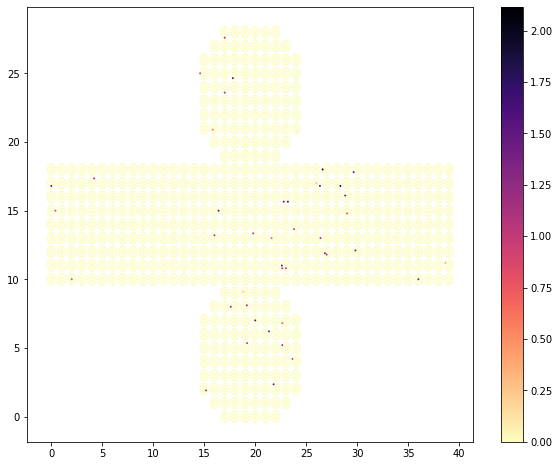

In [40]:
plt.figure(figsize=(10,8))
plot = plt.scatter(xs, ys, c=charges, s=1, cmap=plt.cm.magma_r)
plt.colorbar(plot)

# Plot a neutron event with PMTs as the geometry

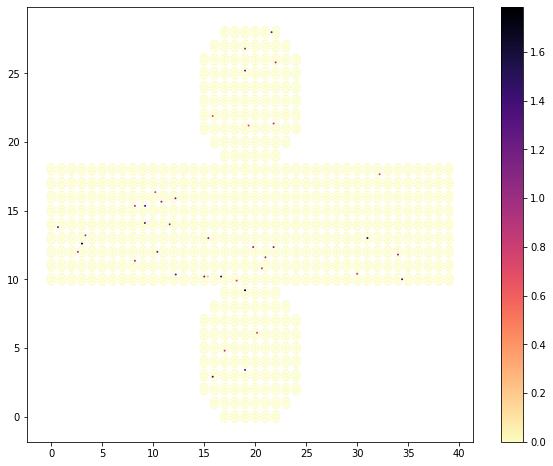

In [41]:
event_number = 4
charges = np.zeros( num_pmts )
xs = []
ys = []

for PMT_index in range(num_pmts):
    mPMT_index = PMT_index//19
    mPMT_pos = mPMT_to_index[mPMT_index]
    PMT_map = mpmt_mapping(PMT_index)
    PMT_pos = [ mPMT_pos[0]+PMT_map[0], mPMT_pos[1]+PMT_map[1] ]
    xs.append(PMT_pos[0])
    ys.append(PMT_pos[1])
    
ev_npz_pmts    = neutron_npz_file['digi_hit_pmt']
ev_npz_charges = neutron_npz_file['digi_hit_charge']
ev_npz_times   = neutron_npz_file['digi_hit_time']

#print(ev_npz_pmts[event_number])
#print(ev_npz_charges[event_number])
#print(ev_npz_times[event_number])

# Assert that charges/times match number of hit PMTs
assert( len(ev_npz_pmts[event_number]) == len(ev_npz_charges[event_number]) )
assert( len(ev_npz_charges[event_number]) == len(ev_npz_times[event_number]) )

for index, pmt in enumerate( ev_npz_pmts[event_number] ):
    charges[pmt] = ev_npz_charges[event_number][index]
    
plt.figure(figsize=(10,8))
plot = plt.scatter(xs, ys, c=charges, s=1, cmap=plt.cm.magma_r)
plt.colorbar(plot)